# Chap 17.3 가짜 이미지 생성

DCGAN(심층 합성곱 적대적 생성 신경망)을 이용하여 실제 유명인의 얼굴 사진과 유사한 이미지 생성

* 얼굴 이미지 데이터셋 주소: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ

In [1]:
using Pkg

In [2]:
pwd()

"/home/bread/JULIA/chap4"

In [3]:
Pkg.activate("/home/bread/JULIA/chap4")

  Activating project at `~/JULIA/chap4`


In [4]:
Pkg.instantiate()

In [5]:
using Flux
import Zygote, Optimisers, MLUtils
using Formatting: format
import Images
#import ImageView # 주피터에선 바로 이미지 볼 수 있으므로 필요없음
import Statistics
using Random: MersenneTwister

In [14]:
using LinearAlgebra
using MLUtils

## 1. 사용자 정의 데이터셋

- 데이터 로더를 시용하기 위해 이미지 파일을 일겅서 전처리하는 사용자 정의 데이터셋을 작성

In [6]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 20 × 12th Gen Intel(R) Core(TM) i7-12700F
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, alderlake)
  Threads: 2 on 20 virtual cores
Environment:
  LD_LIBRARY_PATH = :/usr/local/cuda-11.7/lib64


In [7]:
struct ImageSet
    path::String
    files::Vector{String}
    ImageSet(path::String) = begin
        files = joinpath.(path, readdir(path))
        files = filter(p -> endswith(p, ".jpg"), files)
        return new(path, files)
    end
end

ImageSet 타입은 이미지 파일들이 있는 디렉터리 주소를 생성자의 인수로 받아서, 해당 디렉터리의 jpg 파일들의 주소를 files 필드에 담는다. 

이 타입에 대해 Base.getindex와 Base.length를 정의하면 이 타입을 원소에 임의 접근이 가능한 리스트와 같이 사용할 수 있다. 

In [18]:
function Base.getindex(imgs::ImageSet, i::Int64)
    img = Images.load(imgs.files[i])    # 218 x 178
    img = @view img[21:end-20, :]       # 178 x 178 (center crop)
    img = Images.imresize(img, 64, 64)  # 64 x 64
    img = Images.channelview(img)       # 3 x 64 x 64
    img = permutedims(img, (3,2,1))     # 64 x 64 x 3
    img = (img .- 0.5f0) ./ 0.5f0       # nomalise to [-1,1]
    return img
end
Base.length(imgs::ImageSet) = length(imgs.files)   

Base.getindex 함수 본문을 보면, 요청받은 인덱스의 파일을 로딩한 후, 이미지 자르기와 크기 조정 등을 거쳐(64 x 64 x 3) 형상의 정규화된 배열로 반환한다. 

참고로 다운로드한 이미지들은 전부 (218 x 178) 사이즈이다. 

channelview 등 이미지 전처리 과정은 17.2절에서 이미 다뤘다. 

다음은 ImageSet 객체로 데이터로더를 생성한다.

In [9]:
images = ImageSet("/home/bread/JULIA/chap4/celeba/img_align_celeba")

ImageSet("/home/bread/JULIA/chap4/celeba/img_align_celeba", ["/home/bread/JULIA/chap4/celeba/img_align_celeba/000001.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000002.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000003.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000004.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000005.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000006.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000007.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000008.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000009.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/000010.jpg"  …  "/home/bread/JULIA/chap4/celeba/img_align_celeba/202590.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/202591.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/202592.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/202593.jpg", "/home/bread/JULIA/chap4/celeba/img_align_celeba/202594.jpg", "/home

In [10]:
length(images)

202599

In [16]:
rng = MersenneTwister(1)

MersenneTwister(1)

In [19]:
loader = MLUtils.DataLoader(images, batchsize=128, collate=true, rng=rng, shuffle=true)

1583-element DataLoader(::ImageSet, shuffle=true, batchsize=128, collate=Val{true}(), rng=MersenneTwister(1, (0, 296592, 295590, 428)))
  with first element:
  64×64×3×128 Array{Float32, 4}

* 1,583개의 이미지로 구성된 데이터로더가 생성되었다. 

* ImageSet 타입의 getindex 함수 호출 시 이미지가 메모리에 로딩되기 때문에, 데이터 로더 생성 시에 이미지가 일괄 로딩되는 것이 아니라 미니배치 단위로 요청 시에 해당 이미지들만 로딩된다.

* 로딩된 실제 이미지들 및 DCGAN으로 생성할 가짜 이미지들을 확인할 수 있게 다음과 같은 이미지들을 보여주는 함수를 작성

In [24]:
function show_imgs(batch, ncol)
    data = MLUtils.unbatch(batch)
    imgs = map(data) do arr
        arr = arr .* 0.5f0 .+ 0.5f0
        arr = permutedims(arr, (3, 2, 1))
        Images.colorview(Images.RGB, arr)
    end
    rows = MLUtils.chunk(imgs; size = ncol)
    imgs = map(r -> hcat(r...), rows)
    imgs = vcat(imgs...)
    # ImageView.imshow(imgs) # 주피터 노트북에서는 필요치 않음
end

show_imgs (generic function with 1 method)

- 이 함수는 WHCN 형상의 배열 데이터를 받아서 MLUtils.unbatch로 WHC 형상의 배열을 원소로 가지는 벡터로 바꾼 후,

- 이미지 전처리 과정을 역으로 적용한다. 그리고 ncol 단위로 묶어서 ImageView.imshow 함수로 이미지를 보여준다. 

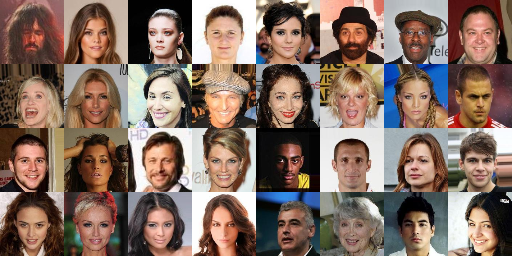

In [25]:
show_imgs(first(loader)[:, :, :, 1:32], 8)

## 2. 생성자와 판별자

- 생성자(generator)와 판별자(discriminator) 모델의 네트워크 구조는 파이토치 튜토리얼과 DCGAN 논문을 참고

- 논문에 따르면 풀링층 대신 합성곱의 스트라이드를 이용하고, 완전 연결층은 은닉층으로 사용하지 말라고 되어 있다. 

- 또한, 배치 정규화를 사용하고, 생성자는 relu 활성화 및 마지막에 tanh, 판별자는 leakyrelu 활성화를 권한다.

먼저 네트워크 가중치 초기화 함수는 다음과 같다. 전치합성곱의 가중치는 논문에서 추천하는 대로 0.02의 표준편차를 가지는 정규분포에서 생성했다.

In [26]:
dcgan_init(rng) = (shape...) -> randn(rng, Float32, shape) * 0.02f0

dcgan_init (generic function with 1 method)

생성자 모델은 다음과 같다. 생성자는 

- 입력으로 받는 노이즈(noise) 벡터의 크기 nz

- 특성 채널수를 조절하는 ngf

- 최종 채널수 nc를 인수로 받고 

- 전치합성곱과 배치 정규화를 거쳐 최종적으로 원소가 -1 ~ 1 사이의 값을 갖는 

- (64 x 64 x nc x batch) 형상의 배열을 생성

In [37]:
function Generator(rng, nz = 100, ngf = 64, nc = 3)
    Chain(
        ConvTranspose((4, 4), nz => ngf * 8; # 4 x 4
            stride = 1, pad = 0, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf * 8, relu),

        ConvTranspose((4, 4), ngf * 8 => ngf * 4; # 8 x 8
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf * 4, relu),

        ConvTranspose((4, 4), ngf * 4 => ngf * 2; # 16 x 16
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf * 2, relu),

        ConvTranspose((4, 4), ngf * 2 => ngf;  # 32 x 32
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ngf, relu),

        ConvTranspose((4, 4), ngf => nc, tanh; # 64 x 64
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
    )
end    

Generator (generic function with 4 methods)

판별자 모델은 

- 입력 채널 수 nc와 특성 채널 수를 조절하는 ndf를 받고 합성곱과 배치 정규화를 거쳐 로짓값을 생성

- 출력 형상은 (1 x 1 x 1 x batch)

In [38]:
function Discriminator(rng, nc = 3, ndf = 64)
    Chain(
        Conv((4, 4), nc => ndf;         # 32 x 32
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        x -> leakyrelu.(x, 0.2f0),

        Conv((4, 4), ndf => ndf * 2;    # 16 x 16
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ndf * 2),
        x -> leakyrelu.(x, 0.2f0),
        
        Conv((4, 4), ndf * 2 => ndf * 4; # 8 x 8
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ndf * 4),
        x -> leakyrelu.(x, 0.2f0),
        
        Conv((4, 4), ndf * 4 => ndf * 8; # 4 x 4
            stride = 2, pad = 1, init = dcgan_init(rng), bias=false),
        BatchNorm(ndf * 8),
        x -> leakyrelu.(x, 0.2f0),
        
        Conv((4, 4), ndf * 8 => 1;
            stride = 1, pad = 0, init = dcgan_init(rng), bias=false),
    )
end
     

Discriminator (generic function with 3 methods)

## 3. 훈련

- 데이터 로더와 에폭 수, 생성자와 판별자 함수에 넘길 nz, ngf, nc, ndf 인수를 받는 훈련 함수

In [39]:
function train_gan(loader, epochs; rng, nz = 100, ngf = 64, nc = 3, ndf = 64)
    netG = Generator(rng, nz, ngf, nc) |> gpu
    netD = Discriminator(rng, nc, ndf) |> gpu

    opt_pars = (0.0002f0, (0.5f0, 0.999f0))
    optG = Optimisers.setup(Optimisers.Adam(opt_pars...), netG);
    optD = Optimisers.setup(Optimisers.Adam(opt_pars...), netD);

    loss_fn = Flux.Losses.logitbinarycrossentropy

    for epoch in 1:epochs
        for (i, real) in enumerate(loader)
            D_x, D_G_z1, D_G_z2 = 0.f0, 0.f0, 0.f0
            show_stat = i % 200 == 0

            real = real |> gpu
            b_size = size(real)[end]
            
            label_real = fill(1.f0, b_size) |> gpu
            label_fake = fill(0.f0, b_size) |> gpu

            noise = randn(rng, Float32, 1, 1, nz, b_size) |> gpu
            fake = netG(noise)

            # Update D network
            errD, errD_grad = Zygote.withgradient(netD) do m
                loss_real = loss_fn(vec(m(real)), label_real)
                loss_fake = loss_fn(vec(m(fake)), label_fake)
                loss_real + loss_fake
            end
            optD, netD = Optimisers.update(optD, netD, errD_grad[1])
        
            !show_stat || (D_x = Statistics.mean(netD(real)))
            !show_stat || (D_G_z1 = Statistics.mean(netD(fake)))

            # Update G network
            errG, errG_grad = Zygote.withgradient(netG) do m
                loss_fn(vec(netD(m(noise))), label_real)
            end
            optG, netG = Optimisers.update(optG, netG, errG_grad[1]);
            
            !show_stat || (D_G_z2 = Statistics.mean(netD(netG(noise))))

            
            # 훈련 중 확률 출력
            if show_stat
                header = "[$epoch / $epochs] [$i / $(length(loader))]"
                loss = format("LossD: {:.4f}\t LossG: {:.4f}", errD, errG)
                probs = format("D(x): {:.4f}\t D(G(z)): {:.4f} / {:.4f}",
                    σ(D_x), σ(D_G_z1), σ(D_G_z2))
                println("$header \t $loss \t $probs")
            end
        end
    end
    netG, netD
end         

train_gan (generic function with 1 method)

먼저 생성자와 판별자 모델 netG와 netD를 생성하고, 각 모델별 옵티마이저를 생성한다.

판별자는 진짜 이미지는 진짜로 판단하고, 가짜 이미지는 가짜로 판단하도록 학습하고, 

생성자는 자신이 생성한 가짜 이미지를 판별자가 진짜로 판단하도록 학습한다. 

Zygote.withgradient 함수를 이용하면 손실값과 기울기를 함께 얻을 수 있다. 

200번째 미니배치마다 판별자의 생성자의 손실값 및 진짜 이미지를 진짜로 판단하는 확률인 D(x)와 

가짜 이미지를 진짜로 판단하는 확률(D(G(z))를 출력한다. 

D(G(z)) 값은 생성자의 학습 전, 그리고 한 스텝 학습 후의 확률을 같이 출력한다. 

생서자에 입력할 노이즈 벡터의 크기를 100으로 하고, 생성자와 판별자를 20에포그로 학습한 결과는 다음과 같다.

In [33]:
nz = 100;
rng = MersenneTwister(1);

In [40]:
@time netG, _ = train_gan(loader, 20; rng = rng, nz = nz);

[1 / 20] [200 / 1583] 	 LossD: 0.5793	 LossG: 2.6408 	 D(x): 0.7688	 D(G(z)): 0.3760 / 0.7315
[1 / 20] [400 / 1583] 	 LossD: 0.3506	 LossG: 4.2814 	 D(x): 0.9568	 D(G(z)): 0.1218 / 0.6479
[1 / 20] [600 / 1583] 	 LossD: 0.6152	 LossG: 1.8734 	 D(x): 0.9754	 D(G(z)): 0.3451 / 0.6344
[1 / 20] [800 / 1583] 	 LossD: 0.7914	 LossG: 5.8742 	 D(x): 0.1838	 D(G(z)): 0.0078 / 0.0528
[1 / 20] [1000 / 1583] 	 LossD: 0.2490	 LossG: 0.8588 	 D(x): 0.8543	 D(G(z)): 0.2142 / 0.5488
[1 / 20] [1200 / 1583] 	 LossD: 0.1249	 LossG: 0.5111 	 D(x): 0.9170	 D(G(z)): 0.1614 / 0.3276
[1 / 20] [1400 / 1583] 	 LossD: 0.2096	 LossG: 0.0944 	 D(x): 0.9325	 D(G(z)): 0.5651 / 0.7080
[2 / 20] [200 / 1583] 	 LossD: 0.2253	 LossG: 0.8214 	 D(x): 0.7356	 D(G(z)): 0.1297 / 0.3271
[2 / 20] [400 / 1583] 	 LossD: 0.2210	 LossG: 0.4437 	 D(x): 0.9256	 D(G(z)): 0.2826 / 0.5286
[2 / 20] [600 / 1583] 	 LossD: 0.7781	 LossG: 4.4110 	 D(x): 0.7927	 D(G(z)): 0.0176 / 0.1272
[2 / 20] [800 / 1583] 	 LossD: 0.2196	 LossG: 0.2960 	 D(

생성자가 충분히 학습되기 전까지는 판별자가 진짜를 판단하는 D(x)의 값은 높고 가짜를 판단하는 D(G(z)의 값은 낮지만, 

생성자가 학습된 이후로는 D(x)와 D(G(z)) 값이 둘 다 0.5에 가까워지는 것을 볼 수 있다. 실제로 생성자가 생성하는 이미지 샘플은 다음과 같다. 

In [41]:
# 모델 임시 저장 

using BSON: @save
@save "face_dcgan.bson" netG = Flux.cpu(netG)

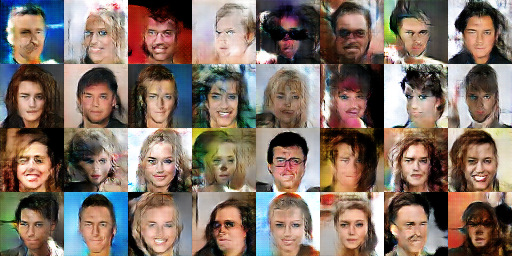

In [42]:
rng = MersenneTwister(1)
fakes = netG(randn(rng, Float32, 1, 1, nz, 32) |> gpu) |> cpu;
show_imgs(fakes, 8)